In [196]:
from os import listdir
from os.path import isfile, join

In [70]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [187]:
def calcTransform(img1, img2, h1, h2):
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    img1_idx = []
    img2_idx = []
    img1_points = []
    img2_points = []
    X_1 = np.array([0.0, 0.0, 0.0])
    X_2 = np.array([0.0, 0.0, 0.0])
    samples = 0
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            x,y = kp1[m.queryIdx].pt
            r1, c1 = int(y), int(x)
            x,y = kp2[m.trainIdx].pt
            r2, c2 = int(y), int(x)
            if h1[r1,c1] != 0 and h2[r2,c2] != 0:
                img1_idx.append(m.queryIdx)
                img1_points.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], h1[r1,c1]])
                X_1 += img1_points[-1]
                img2_idx.append(m.trainIdx)
                img2_points.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], h2[r2,c2]])
                X_2 += img2_points[-1]
                samples += 1
    X_1 /= samples
    X_2 /= samples
    X1_points = np.array(img1_points)
    X2_points = np.array(img2_points)
    SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
    U,S,V = np.linalg.svd(SVD_input)
    R = V.T @ U.T
    t = X_2 - R @ X_1
    transformation = np.zeros((4,4))
    transformation[0:3,0:3] = R
    transformation[0:3,3] = t
    transformation[3,3] = 1
    return transformation
    

In [188]:
img1 = cv.imread('rgbd_dataset_freiburg1_xyz/rgb/1305031102.175304.png',0)          # queryImage
img2 = cv.imread('rgbd_dataset_freiburg1_xyz/rgb/1305031102.211214.png',0)          # trainImage
h1 = cv.imread('rgbd_dataset_freiburg1_xyz/depth/1305031102.160407.png',-cv.IMREAD_ANYDEPTH)/5000          # queryImage
h2 = cv.imread('rgbd_dataset_freiburg1_xyz/depth/1305031102.194330.png',-cv.IMREAD_ANYDEPTH)/5000          # trainImage

In [189]:
transformation = calcTransform(img1, img2, h1, h2)

In [190]:
transformation

array([[ 9.99996237e-01, -2.74266717e-03,  6.37649434e-05,
         6.20032281e+00],
       [ 2.74266931e-03,  9.99996238e-01, -3.34948109e-05,
        -4.46119299e+00],
       [-6.36728384e-05,  3.36695710e-05,  9.99999997e-01,
        -7.75546210e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [182]:
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
img1_idx = []
img2_idx = []
img1_points = []
img2_points = []
X_1 = np.array([0.0, 0.0, 0.0])
X_2 = np.array([0.0, 0.0, 0.0])
samples = 0
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        x,y = kp1[m.queryIdx].pt
        r1, c1 = int(y), int(x)
        x,y = kp2[m.trainIdx].pt
        r2, c2 = int(y), int(x)
        if h1[r1,c1] != 0 and h2[r2,c2] != 0:
            img1_idx.append(m.queryIdx)
            img1_points.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], h1[r1,c1]])
            X_1 += img1_points[-1]
            img2_idx.append(m.trainIdx)
            img2_points.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], h2[r2,c2]])
            X_2 += img2_points[-1]
            samples += 1
X_1 /= samples
X_2 /= samples
X1_points = np.array(img1_points)
X2_points = np.array(img2_points)
SVD_input = (X1_points-X_1).T @ (X2_points-X_2)
U,S,V = np.linalg.svd(SVD_input)
R = V.T @ U.T
t = X_2 - R @ X_1

In [178]:
t

array([ 5.84760282, -4.33259985, -0.00854073])

In [161]:
X_1

array([[246.47652797, 312.09240803,   1.30344196]])

In [162]:
X1_points

array([[  9.08279037, 432.36920166,   1.0284    ],
       [ 13.30071068, 423.29031372,   1.0474    ],
       [ 16.52820015, 468.69778442,   0.9318    ],
       ...,
       [583.84448242, 410.84631348,   1.0222    ],
       [585.01202393, 266.62384033,   1.171     ],
       [585.15313721, 227.38044739,   1.1328    ]])

In [218]:
mypath = "rgbd_dataset_freiburg1_floor/rgb/"
rgb_files = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])
mypath = "rgbd_dataset_freiburg1_floor/depth/"
depth_files = sorted([f for f in listdir(mypath) if isfile(join(mypath, f))])

In [221]:
last_rgb = None
last_h = None
position = np.array([0,0,0,1])
positions = []
i = 0
for rgb, h in zip(rgb_files, depth_files):
    i += 1
    if last_rgb is None and last_h is None:
        last_rgb = cv.imread('rgbd_dataset_freiburg1_floor/rgb/'+rgb,0)
        last_h = cv.imread('rgbd_dataset_freiburg1_floor/depth/'+h,-cv.IMREAD_ANYDEPTH)/5000
    else:
        rgb = cv.imread('rgbd_dataset_freiburg1_floor/rgb/'+rgb,0)
        h = cv.imread('rgbd_dataset_freiburg1_floor/depth/'+h,-cv.IMREAD_ANYDEPTH)/5000
        transformation = calcTransform(last_rgb, rgb, last_h, h)
        position = transformation @ position
        positions.append(position.copy())
        last_rgb = rgb
        last_h = h
    if i % 100 == 0:
        print(i)
        

100
200
300
400
500
600
700
800
900
1000
1100
1200


In [201]:
depth_files

['1305031102.160407.png',
 '1305031102.194330.png',
 '1305031102.226738.png',
 '1305031102.262886.png',
 '1305031102.295279.png',
 '1305031102.329195.png',
 '1305031102.363013.png',
 '1305031102.394772.png',
 '1305031102.427815.png',
 '1305031102.462395.png',
 '1305031102.494271.png',
 '1305031102.526330.png',
 '1305031102.562224.png',
 '1305031102.594158.png',
 '1305031102.626818.png',
 '1305031102.663273.png',
 '1305031102.695165.png',
 '1305031102.728423.png',
 '1305031102.763549.png',
 '1305031102.794978.png',
 '1305031102.828537.png',
 '1305031102.862808.png',
 '1305031102.894167.png',
 '1305031102.926851.png',
 '1305031102.962137.png',
 '1305031102.994164.png',
 '1305031103.027881.png',
 '1305031103.062273.png',
 '1305031103.094040.png',
 '1305031103.129109.png',
 '1305031103.162795.png',
 '1305031103.191061.png',
 '1305031103.227845.png',
 '1305031103.262576.png',
 '1305031103.294208.png',
 '1305031103.327550.png',
 '1305031103.362405.png',
 '1305031103.394162.png',
 '1305031103

In [222]:
x = np.array(positions).T[0]
y = np.array(positions).T[1]
z = np.array(positions).T[2]
c = range(len(x))

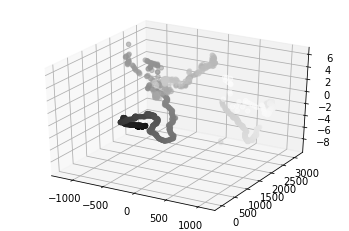

In [223]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=c)
plt.show()